# Carvana Image Masking Challenge

#### Segmentation of images using U-Net Convolutional Neural Network

### Import Statements

In [1]:
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.datasets import load_sample_image
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import load_img, img_to_array
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Dropout
from keras.models import Model
from os.path import join
from os import listdir
from keras.preprocessing import image
import os
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = (20, 20)

Using TensorFlow backend.


In [2]:
from lib import augmentations as aug
from lib import unet

### Constants

In [3]:
DATA_DIR = join(os.getcwd(), 'data')
TRAIN_DIR = join(DATA_DIR, 'train')
MASK_DIR = join(DATA_DIR, 'train_masks')
TRAIN_IMAGE_LIST = listdir(TRAIN_DIR)
MASK_IMAGE_LIST = listdir(MASK_DIR)
ASPECT_RATIO = 1280 / 1918

### Splitting the data

In [4]:
train_images, test_images, train_masks, test_masks = train_test_split(TRAIN_IMAGE_LIST, MASK_IMAGE_LIST, test_size=0.2)

### Data Augumentation 

In [5]:
def recreate_image(codebook, labels, w, h):
    '''
    Recreate the (compressed) image from the code book & labels
    '''
    d = codebook.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image

In [6]:
def color_quantize(img, target_colors):
    '''
    img: Source Image to perform Color Quantization.
    target_colors: The number of bit of colors to quantize.
    '''
    img = img_to_array(img)
    image_array = np.reshape(img, (img.shape[0] * img.shape[1], img.shape[2]))
    image_array_sample = shuffle(image_array, random_state=0)[:1000]
    kmeans = KMeans(n_clusters=target_colors, random_state=0).fit(image_array_sample)
    labels = kmeans.predict(image_array)
    return recreate_image(kmeans.cluster_centers_, labels, img.shape[0], img.shape[1])

In [7]:
def image_generator_function(images, masks, batch_size, img_width = None, num_colors = 256):
    
    '''
    images: Array of image names
    masks: Array of mask names
    batch_size: The number of images to be consider in one batch.
    num_colors = target number of colors for kmeans algorithm. (Default = 256)
    img_width: The width to which the original image is resized while maintaining aspect ratio. Does not resize if no parameters passed.
    '''
    
    img_dim = [int(ASPECT_RATIO * img_width), img_width] if img_width is not None else None
    
    while True:
        
        random_indices = np.random.choice(len(images), batch_size)
        
        imgs = [img_to_array(color_quantize(load_img(join(TRAIN_DIR, images[index]), target_size = img_dim), num_colors)) / 255 for index in random_indices]
        
        masks = [img_to_array(load_img(join(MASK_DIR, masks[index]), target_size = img_dim)) / 255 for index in random_indices]
        
        yield np.array(imgs), np.array(masks)

In [8]:
train_generator = image_generator_function(train_images, train_masks, 5, 500, 16)
img_tmp, mask_tmp = next(train_generator)

img, mask = aug.random_augmentation(img_tmp,
                                mask_tmp,
                                flip_chance=0,
                                rotate_chance=0,
                                rotate_limit=(-20,20),
                                shift_chance=0, 
                                shift_limit_w=(-0.1, 0.1), 
                                shift_limit_h=(-0.1, 0.1),
                                zoom_chance=0,
                                zoom_range=(0.8, 1), 
                                shear_chance=1,
                                shear_range=(-0.5, 0.5))

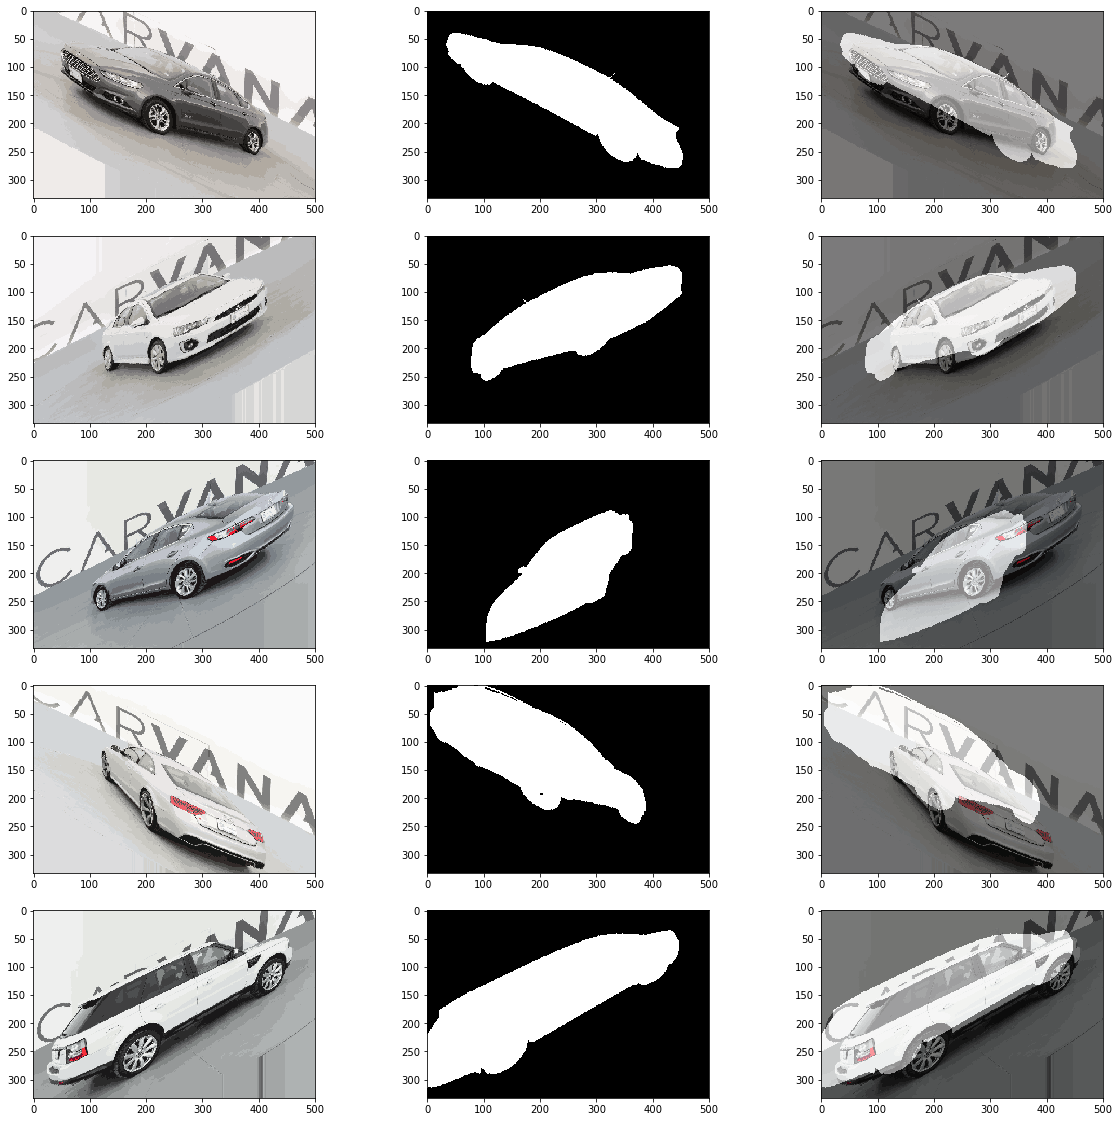

In [9]:
plot = 1
for i in range(img.shape[0]):
    plt.subplot(img.shape[0], 3, plot)
    plt.imshow(img[i])
    plot += 1
    plt.subplot(img.shape[0], 3, plot)
    plt.imshow(mask[i])
    plot += 1
    plt.subplot(img.shape[0], 3, plot)
    plt.imshow(img[i])
    plt.imshow(mask[i], alpha=0.5)
    plot += 1
plt.show()

In [10]:
model = unet.get_unet_model([128, 128, 3])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 128, 128, 3)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 128, 128, 64)  1792        input_1[0][0]                    
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 128, 128, 64)  0           conv2d_1[0][0]                   
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 128, 128, 64)  36928       dropout_1[0][0]                  
___________________________________________________________________________________________